# Análise de Dados das Eleições 

O trabalho neste notebook tem tem como objetivo fazer um análise e construir visualizações de dados relacionados às eleições. Para tal, serão utilizados os dados das eleições que podem ser acessados a partir do site [Base dos Dados](https://basedosdados.org). O notebook está organizado da seguinte maneira:

1. Bibliotecas utilizadas
2. Sobre a análise
3. Funções auxiliares
4. Análise e visualizações
    - Lista de Candidatos
    - Agrupamento por Ano e Gênero
    - Recorte de Aracaju
    - Recorte por Cidade
5. Visualização final


## 1. Bibliotecas utilizadas 

Estão sendo utilizados os seguintes pacotes: 

* `basedosdados`: API do projeto Base dos Dados para acesso as base de dados e realizar consultas. 
* `pandas`: Biblioteca para manipulação das bases com python.
* `plotly`: biblioteca para criação das visualizações auxiliares.
* `D3.js`: biblioteca JavaScript para criação da visualização final, via notebooks no [ObservableHQ](observablehq.com/). O código está na pasta `code/viz`.

In [7]:
#imports necessários

import pandas as pd
import basedosdados as bd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


## 2. Sobre a análise

O objetivo é usar os dados das eleições para traçar o perfil dos candidados ao longo das últimas eleições. Para isso, serão utilizadas as seguintes tabelas:

* `basedosdados.br_tse_eleicoes.candidados`: para extrair a lista de candidados das últimas eleições. 
* `basedosdados.br_tse_eleicoes.resultados_candidatos`: para extrair informações como quantidade de votos e resultado. 
* `basedosdados.br_bd_diretorios_brasil.municipio`: utilizada para pegar os nomes dos municípios.

Para restringir os escopo de nossa análise vamos focar em algunas aspectos: 

* Serão analisados os dados somente do estado de Sergipe. No entanto, o código pode ser facilmente modificado para gerar análises de outros estados. 
* Vamos focar nos dados dos vereadores por ter um maior número de candidados e permitir uma melhor análise quando agruparmos esses dados. 
* As análises vão focar em enteder a distribuição dos candidados de acordo com o gênero.
* Serão feitos alguns recortes para visualizar aspectos de raça, aspectos espcíficos da capital e de alguns municípios. 


## 3. Funções Auxiliares

Espaço para algumas funções auxiliares necessárias para a execução do código.

In [8]:
def calculate_total_percent(data):
    for index, row in data.iterrows():
        sum_ = data.loc[index[0], 'id_candidato_bd'].sum()
        data.loc[index[0], 'total'] = int(sum_)

    data['porcentagem'] = data['id_candidato_bd']/data['total']
    data.reset_index(inplace=True)
    data.rename(columns={'id_candidato_bd': 'total_por_genero'},inplace=True)
    return data
    

## 4. Análise e Visualizações

### Lista de Candidatos

Os dados foram coletados diretamente do `datalake` do projeto Base dos Dados. O objetivo foi usar os dados das eleições para mostrar um perfil das candidaturas das câmaras municipais do estado de Sergipe nos últimos 20 anos. O enfoque foi mostrar aspectos relacionados ao gênero das pessoas candidatas e eleitas. A consulta utilizada foi a seguinte: 

```sql 
SELECT 
    b1.ano, b2.sigla_uf, b2.id_municipio, b3.nome as nome_municipio, b1.tipo_eleicao, 
    b1.id_candidato_bd, b1.nome_urna, b1.sigla_partido, 
    b1.cargo, b1.situacao, b2.resultado, b2.votos, b1.genero, b1.raca, b1.idade
FROM
    `basedosdados.br_tse_eleicoes.candidatos` b1,
    `basedosdados.br_tse_eleicoes.resultados_candidato` b2
INNER JOIN 
    `basedosdados.br_bd_diretorios_brasil.municipio` b3
ON 
    b3.id_municipio = b1.id_municipio
WHERE 
  b1.id_candidato_bd = b2.id_candidato_bd and 
  b1.ano = b2.ano and b2.sigla_uf = 'SE' and 
  b2.cargo = 'vereador'
ORDER BY 
    b1.ano, b1.id_candidato_bd
```

In [9]:
query_candidatos = """
SELECT 
    b1.ano, b2.sigla_uf, b2.id_municipio, b3.nome as nome_municipio, b1.tipo_eleicao, 
    b1.id_candidato_bd, b1.nome_urna, b1.sigla_partido, 
    b1.cargo, b1.situacao, b2.resultado, b2.votos, b1.genero, b1.raca, b1.idade
FROM
    `basedosdados.br_tse_eleicoes.candidatos` b1,
    `basedosdados.br_tse_eleicoes.resultados_candidato` b2
INNER JOIN 
    `basedosdados.br_bd_diretorios_brasil.municipio` b3
ON 
    b3.id_municipio = b1.id_municipio
WHERE 
  b1.id_candidato_bd = b2.id_candidato_bd and 
  b1.ano = b2.ano and b2.sigla_uf = 'SE' and 
  b2.cargo = 'vereador'
ORDER BY 
    b1.ano, b1.id_candidato_bd
"""

In [10]:
# Execução da consulta
df_candidatos = bd.read_sql(query=query_candidatos,billing_project_id='adolfo-dev')

Downloading: 100%|██████████| 28308/28308 [00:05<00:00, 4747.42rows/s]


In [11]:
# Base coletada
df_candidatos

,ano,sigla_uf,id_municipio,nome_municipio,tipo_eleicao,id_candidato_bd,nome_urna,sigla_partido,cargo,situacao,resultado,votos,genero,raca,idade
0,2000,SE,2806305,Santa Luzia do Itanhy,eleicao ordinaria,1000073,João Donato Filho,PSDB,vereador,deferido,suplente,28,masculino,None,36.0
1,2000,SE,2804805,Nossa Senhora do Socorro,eleicao ordinaria,1002012,Galego Pedreiro,PGT,vereador,deferido,nao eleito,27,masculino,None,36.0
2,2000,SE,2800308,Aracaju,eleicao ordinaria,1002075,Ivanildo Da Silva,PTB,vereador,deferido,suplente,308,masculino,None,36.0
3,2000,SE,2807501,Tomar do Geru,eleicao ordinaria,1002761,Vardo,PDT,vereador,deferido,suplente,71,masculino,None,54.0
4,2000,SE,2805604,Porto da Folha,eleicao ordinaria,1003666,Pedro Rodrigues De Souza,PSL,vereador,deferido,suplente,136,masculino,None,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28303,2020,SE,2803203,Itaporanga d'Ajuda,eleicao ordinaria,99864,Sandro Do Sapé,CIDADANIA,vereador,deferido,nao eleito,26,masculino,parda,37.0
28304,2020,SE,2801405,Carira,eleicao ordinaria,9991,José Calazans,PSB,vereador,deferido,nao eleito,101,masculino,parda,42.0
28305,2020,SE,2801702,Cristinápolis,eleicao ordinaria,999139,Bambam Do Povão,PT,vereador,deferido,suplente,115,feminino,parda,37.0
28306,2020,SE,2803500,Lagarto,eleicao ordinaria,999390,Telma Do Santo Antonio,PSD,vereador,deferido,suplente,34,feminino,parda,63.0


### Agrupamento por Ano e Gênero

O primeiro passo foi agrupar as informações de todos os candidatos por ano e gênero para obter a proporção de candidaturas por gênero em cada ano do pleito eleitoral. A função `calculate_total_percent`, definida anteriormente, processa o resultado do agrupamento para obter as porcentagens por gênero. 

In [12]:
df_vereadores_total = df_candidatos[['id_candidato_bd','ano','genero']].groupby(by=['ano','genero']).count()
df_vereadores_total = calculate_total_percent(df_vereadores_total)
df_vereadores_total

,ano,genero,total_por_genero,total,porcentagem
0,2000,feminino,853,4372.0,0.195105
1,2000,masculino,3519,4372.0,0.804895
2,2004,feminino,943,4050.0,0.232840
3,2004,masculino,3107,4050.0,0.767160
4,2008,feminino,816,3700.0,0.220541
5,2008,masculino,2884,3700.0,0.779459
6,2012,feminino,1582,5000.0,0.316400
7,2012,masculino,3418,5000.0,0.683600
8,2016,feminino,1680,5106.0,0.329025
9,2016,masculino,3426,5106.0,0.670975


Uma tabela semelhante a anterior foi gerada par as pessoas eleitas. Para selecionar os vereadores eleitos, os dados foram filtrados pelos resultados: `['eleito por qp','eleito','eleito por media']`.

In [13]:
df_query_vereadores_eleitos = df_candidatos.query("resultado in ['eleito por qp','eleito','eleito por media']", engine='python')
df_vereadores_eleitos = df_query_vereadores_eleitos[['id_candidato_bd','ano','genero']].groupby(by=['ano','genero']).count()
df_vereadores_eleitos = calculate_total_percent(df_vereadores_eleitos)
df_vereadores_eleitos

,ano,genero,total_por_genero,total,porcentagem
0,2000,feminino,136,797.0,0.170640
1,2000,masculino,661,797.0,0.829360
2,2004,feminino,115,693.0,0.165945
3,2004,masculino,578,693.0,0.834055
4,2008,feminino,103,695.0,0.148201
5,2008,masculino,592,695.0,0.851799
6,2012,feminino,122,795.0,0.153459
7,2012,masculino,673,795.0,0.846541
8,2016,feminino,129,801.0,0.161049
9,2016,masculino,672,801.0,0.838951


A visualização a seguir nos ajuda a ver a diferença de proporção entre as pessoas candidatas e eleitas. Os dados foram filtrados apenas para informações do gênero feminino que é o foco desta análise. 

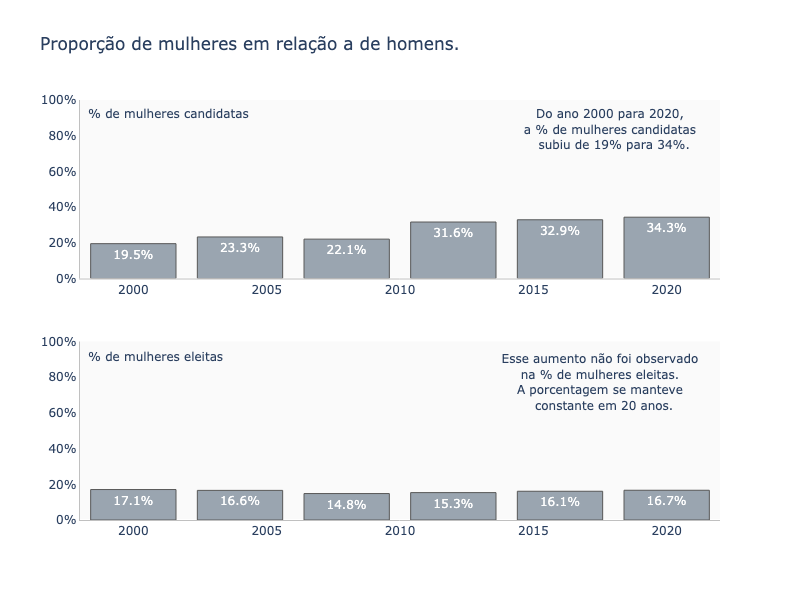

In [14]:
# Filtrando os dados do gênero feminino
data_selected1 = df_vereadores_total.query("genero == 'feminino'") 
data_selected2 = df_vereadores_eleitos.query("genero == 'feminino'")

# Construindo a visualização

fig = go.Figure()

fig = make_subplots(
    rows=2, cols=1,
    row_heights=[0.5,0.5],
)


fig.add_trace(go.Bar(
            x=data_selected1.ano, 
            y=data_selected1.porcentagem, 
            text=data_selected1.porcentagem,
            texttemplate='%{y:.1%}',
            hovertemplate='Ano: %{x} <br /> %: %{y:.1%}',
            opacity=0.8,
            
        ), row=1, col=1)

fig.add_trace(go.Bar(
            x=data_selected2.ano, 
            y=data_selected2.porcentagem, 
            text=data_selected2.porcentagem,
            texttemplate='%{y:.1%}',
            hovertemplate='Ano: %{x} <br /> %: %{y:.1%}',
            opacity=0.8,
        ), row=2, col=1)

fig.update_layout(title="Proporção de mulheres em relação a de homens.",
                  plot_bgcolor="#FAFAFA",
                  showlegend=False,
                  width=800,
                  height=600,
                  
                  )

fig.update_traces(marker_color='#708090', marker_line_color='#121212',
                  marker_line_width=1, opacity=0.7)


fig.layout.yaxis1.tickformat=',.0%'
fig.layout.yaxis1.range=[0,1]
fig.layout.yaxis2.tickformat=',.0%'
fig.layout.yaxis2.range=[0,1]

fig.add_annotation(x=0.01, y=0.99,
            text="% de mulheres candidatas",
            showarrow=False,
            xref='paper',
            yref='paper',
            )

fig.add_annotation(x=0.01, y=0.39,
            text="% de mulheres eleitas",
            showarrow=False,
            xref='paper',
            yref='paper',
            )

fig.add_annotation(x=0.99, y=0.99,
            text="Do ano 2000 para 2020, <br />a % de mulheres candidatas <br /> subiu de 19% para 34%.",
            showarrow=False,
            xref='paper',
            yref='paper',
            width=200,
            xanchor="right"
            )

fig.add_annotation(x=0.99, y=0.25,
            text="Esse aumento não foi observado <br />na % de mulheres eleitas. <br />A porcentagem se manteve <br /> constante em 20 anos.",
            showarrow=False,
            xref='paper',
            yref='paper',
            width=220,
            xanchor="right"
            )

fig.update_yaxes( 
  showgrid=False,
  linecolor="#C0C0C0",
  linewidth=1
)

fig.update_xaxes(  
  showgrid=False,
  linecolor="#C0C0C0",
  linewidth=1
)

fig.show("png")


Para a visualização final, serão utilizadas os dataframes processados nesta etapa. Para isso, esses dados serão salvos na pasta `output` em formato `.csv`. Esses arquivos foram carregados no `ObservableHQ` para alimentar a visualização final que pode ser vista no final deste documento. 

In [15]:
# Geração dos Arquivos para a visualização final
df_vereadores_total.to_csv("../output/total_vereadores_por_ano_genero.csv", index=False)

In [16]:
# Geração dos Arquivos para a visualização final
df_vereadores_eleitos.to_csv("../output/total_vereadores_eleitos_por_ano_genero.csv", index=False)

### Agrupamento por Ano, Gênero e Cor/Raça

A proposta agora é fazer um recorte dessas proporções de acordo com a cor e a raça. Como o objetivo é olhar somente dentro das pessoas de gênero feminino, os dados foram filtrados para tal.

In [18]:
df_vereadores_total_raca = df_candidatos.query("genero == 'feminino'")
df_vereadores_total_raca = df_vereadores_total_raca[['id_candidato_bd','ano','genero','raca']].groupby(by=['ano','genero','raca']).count()
df_vereadores_total_raca = calculate_total_percent(df_vereadores_total_raca)
df_vereadores_total_raca

,ano,genero,raca,total_por_genero,total,porcentagem
0,2016,feminino,amarela,14,1680.0,0.008333
1,2016,feminino,branca,385,1680.0,0.229167
2,2016,feminino,indigena,4,1680.0,0.002381
3,2016,feminino,parda,1131,1680.0,0.673214
4,2016,feminino,preta,146,1680.0,0.086905
5,2020,feminino,amarela,12,2063.0,0.005817
6,2020,feminino,branca,442,2063.0,0.214251
7,2020,feminino,indigena,3,2063.0,0.001454
8,2020,feminino,parda,1338,2063.0,0.648570
9,2020,feminino,preta,268,2063.0,0.129908


O mesmo recorte foi feito só para as pessoas eleitas. 

In [19]:
df_query_vereadores_eleitos_raca = df_candidatos.query("genero == 'feminino' and resultado in ['eleito por qp','eleito','eleito por media']", engine='python')
df_vereadores_eleitos_raca = df_query_vereadores_eleitos_raca[['id_candidato_bd','ano','genero','raca']].groupby(by=['ano','genero','raca']).count()
df_vereadores_eleitos_raca = calculate_total_percent(df_vereadores_eleitos_raca)
df_vereadores_eleitos_raca

,ano,genero,raca,total_por_genero,total,porcentagem
0,2016,feminino,branca,42,129.0,0.325581
1,2016,feminino,parda,84,129.0,0.651163
2,2016,feminino,preta,3,129.0,0.023256
3,2020,feminino,amarela,3,131.0,0.022901
4,2020,feminino,branca,35,131.0,0.267176
5,2020,feminino,indigena,1,131.0,0.007634
6,2020,feminino,parda,83,131.0,0.633588
7,2020,feminino,preta,9,131.0,0.068702


O foco da visualização é mostrar a % no ano de 2020. Os dados serão filtrados para este ano. 

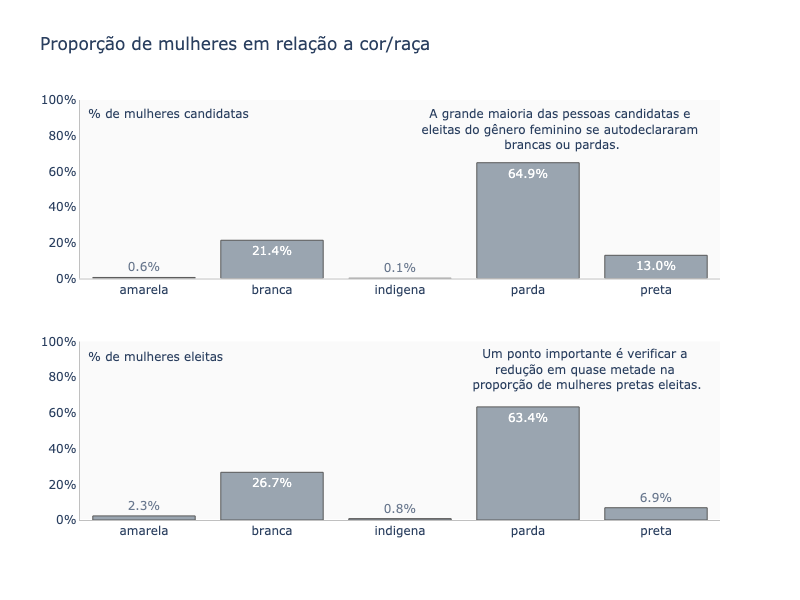

In [20]:
data_selected3 = df_vereadores_total_raca.query("ano == 2020") # Foi filtrado só o ano de 2020
data_selected4 = df_vereadores_eleitos_raca.query("ano == 2020") # Foi filtrado só o ano de 2020

# Construindo a visualização

fig = go.Figure()

fig = make_subplots(
    rows=2, cols=1,
    row_heights=[0.5,0.5],
)


fig.add_trace(go.Bar(
            x=data_selected3.raca, 
            y=data_selected3.porcentagem, 
            text=data_selected3.porcentagem,
            texttemplate='%{y:.1%}',
            hovertemplate='Ano: %{x} <br /> %: %{y:.1%}',
            opacity=0.8,
            
        ), row=1, col=1)

fig.add_trace(go.Bar(
            x=data_selected4.raca, 
            y=data_selected4.porcentagem, 
            text=data_selected4.porcentagem,
            texttemplate='%{y:.1%}',
            hovertemplate='Ano: %{x} <br /> %: %{y:.1%}',
            opacity=0.8,
        ), row=2, col=1)

fig.update_layout(title="Proporção de mulheres em relação a cor/raça",
                  plot_bgcolor="#FAFAFA",
                  showlegend=False,
                  width=800,
                  height=600,
                  
                  )

fig.update_traces(marker_color='#708090', marker_line_color='#121212',
                  marker_line_width=1, opacity=0.7)


fig.layout.yaxis1.tickformat=',.0%'
fig.layout.yaxis1.range=[0,1]
fig.layout.yaxis2.tickformat=',.0%'
fig.layout.yaxis2.range=[0,1]

fig.add_annotation(x=0.01, y=0.99,
            text="% de mulheres candidatas",
            showarrow=False,
            xref='paper',
            yref='paper',
            )

fig.add_annotation(x=0.01, y=0.39,
            text="% de mulheres eleitas",
            showarrow=False,
            xref='paper',
            yref='paper',
            )

fig.add_annotation(x=0.99, y=0.99,
            text="A grande maioria das pessoas candidatas e <br />eleitas do gênero feminino se autodeclararam <br />brancas ou pardas.",
            showarrow=False,
            xref='paper',
            yref='paper',
            width=300,
            xanchor="right"
            )

fig.add_annotation(x=0.99, y=0.30,
            text="Um ponto importante é verificar a <br />redução em quase metade na <br />proporção de mulheres pretas eleitas.",
            showarrow=False,
            xref='paper',
            yref='paper',
            width=250,
            xanchor="right"
            )

fig.update_yaxes( 
  showgrid=False,
  linecolor="#C0C0C0",
  linewidth=1
)

fig.update_xaxes(  
  showgrid=False,
  linecolor="#C0C0C0",
  linewidth=1
)

fig.show("png")


Para a visualização final, serão utilizadas os dataframes processados nesta etapa. Para isso, esses dados serão salvos na pasta `output` em formato `.csv`. Esses arquivos foram carregados no `ObservableHQ` para alimentar a visualização final que pode ser vista no final deste documento. 

In [21]:
df_vereadores_total_raca.to_csv("../output/total_vereadores_por_ano_genero_raca.csv", index=False)

In [22]:
df_vereadores_eleitos_raca.to_csv("../output/total_vereadores_eleitos_por_ano_genero_raca.csv", index=False)

### Recorte de Aracaju

Com o objetivo de olhar mais especificamente para o município de Aracaju (capital do estado), foi filtrado todos os candidatos do muicípio que foram eleitos. A proposta é olhar o % de mulheres eleitas no município, além da posição ocupada de acordo com o número de votos. 

In [23]:
df_vereadores_eleitos_aracaju = df_query_vereadores_eleitos.query("id_municipio == '2800308'")
df_vereadores_eleitos_aracaju.sort_values(by=['ano','votos'], inplace=True, ascending=[True, False])
df_vereadores_eleitos_aracaju

,ano,sigla_uf,id_municipio,nome_municipio,tipo_eleicao,id_candidato_bd,nome_urna,sigla_partido,cargo,situacao,resultado,votos,genero,raca,idade
3785,2000,SE,2800308,Aracaju,eleicao ordinaria,829690,Barreto,PPS,vereador,deferido,eleito,4947,masculino,None,36.0
3271,2000,SE,2800308,Aracaju,eleicao ordinaria,722885,Chiquinho,PT,vereador,deferido,eleito,4729,masculino,None,44.0
3297,2000,SE,2800308,Aracaju,eleicao ordinaria,723744,Sérgio Carlos,PSDB,vereador,deferido,eleito,4046,masculino,None,42.0
2931,2000,SE,2800308,Aracaju,eleicao ordinaria,658924,Bomfim,PPS,vereador,deferido,eleito por media,3300,masculino,None,56.0
2827,2000,SE,2800308,Aracaju,eleicao ordinaria,626985,Carlos Magal,PT,vereador,deferido,eleito,3168,masculino,None,47.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27544,2020,SE,2800308,Aracaju,eleicao ordinaria,694328,Professora Ângela Melo,PT,vereador,deferido,eleito por qp,1882,feminino,amarela,64.0
24410,2020,SE,2800308,Aracaju,eleicao ordinaria,1591,Sgt. Byron Estrelas Do Mar,REPUBLICANOS,vereador,deferido,eleito por media,1743,masculino,parda,42.0
27736,2020,SE,2800308,Aracaju,eleicao ordinaria,774078,Paquito De Todos,SOLIDARIEDADE,vereador,deferido,eleito por media,1486,masculino,branca,59.0
22362,2020,SE,2800308,Aracaju,eleicao ordinaria,1038140,Cícero Do Santa Maria,PODE,vereador,deferido,eleito por media,1470,masculino,branca,57.0


Para a visualização é necessário a informação da posição ocupada por cada pessoa eleita no pleito. Essa informação não está na tabela, mas pode ser extraída a partir do total de votos. O código a seugir seleciona as colunas de interesse e gera as informações necessárias. 

In [45]:
%%capture --no-display
data_filter_aracaju = df_vereadores_eleitos_aracaju[['ano','genero','votos']]
data_filter_aracaju.loc[:, 'posicao'] = data_filter_aracaju.groupby(by=['ano']).votos.transform(lambda x : pd.factorize(x)[0]+1)
data_filter_aracaju

,ano,genero,votos,posicao
3785,2000,masculino,4947,1
3271,2000,masculino,4729,2
3297,2000,masculino,4046,3
2931,2000,masculino,3300,4
2827,2000,masculino,3168,5
...,...,...,...,...
27544,2020,feminino,1882,20
24410,2020,masculino,1743,21
27736,2020,masculino,1486,22
22362,2020,masculino,1470,23


A tabela anterior tem as informações necessárias para nossa análise, mas é defícil de enxerga-las. Para facilitar, os dados foram plotados na visualização a seguir. É possível perceber que ao longo de 20 anos foram poucas as vezes que as mulheres ocuparam as primeiras posições nas votações para a câmara municipal de Aracaju. Além disso, o percentual de participação delas foi quase constante ao longo dos anos. Os pontos destacados representam as candidaturas de mulheres. 

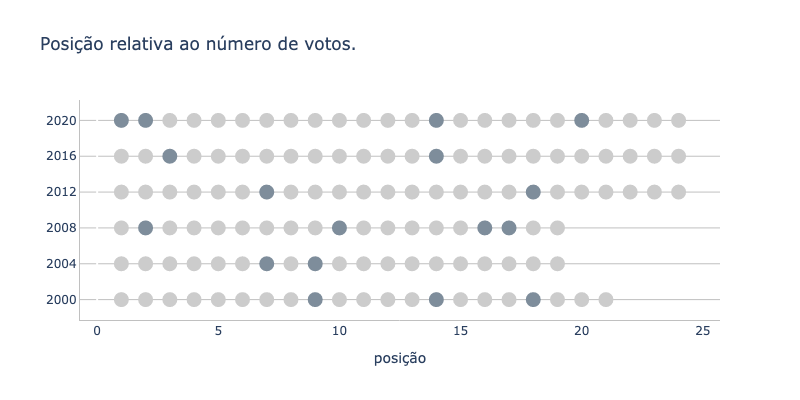

In [53]:
data_filter_aracaju['ano'] = data_filter_aracaju['ano'].astype('str')

data_filter_aracaju.loc[data_filter_aracaju['genero'] == 'masculino', 'color'] = '#cccccc'
data_filter_aracaju.loc[data_filter_aracaju['genero'] == 'feminino', 'color'] = '#7e8d9b'


fig = go.Figure()
fig.add_trace(go.Scatter(
    y=data_filter_aracaju['ano'],
    x=data_filter_aracaju['posicao'],
    mode="markers",
    marker_size = 15,
    marker_color=data_filter_aracaju['color']
))

fig.update_yaxes( 
  showgrid=True,
  gridcolor="#C0C0C0",
  linecolor="#C0C0C0",
  linewidth=1,
  tickfont_size=12
)

fig.update_xaxes(  
  showgrid=False,
  
  linecolor="#C0C0C0",
  linewidth=1
)

fig.update_layout(title="Posição relativa ao número de votos.",
                  xaxis_title="posição",
                  height=400,
                  width=800,
                  plot_bgcolor="#FFFFFF"
                  )


fig.show("png")

Para a visualização final, serão utilizadas os dataframes processados nesta etapa. Para isso, esses dados serão salvos na pasta `output` em formato `.csv`. Esses arquivos foram carregados no `ObservableHQ` para alimentar a visualização final que pode ser vista no final deste documento. 

In [55]:
df_vereadores_eleitos_aracaju.to_csv("../output/lista_vereadores_eleitos_aracaju_por_ano.csv", index=False)

### Recorte por Cidade

Por fim, outra seleção necessária foi a de verificar a distribuição de gênero de acordo com os municípios. Da lista geral de candidatos, foram gerados os dados somente dos eleitos de todos os 75 municípios do estdo. O objetivo é ver como a proporção de mulheres varia neles. 

In [56]:
df_vereadores_eleitos = df_candidatos.query("resultado in ['eleito por qp','eleito','eleito por media']", engine='python')
df_vereadores_eleitos

,ano,sigla_uf,id_municipio,nome_municipio,tipo_eleicao,id_candidato_bd,nome_urna,sigla_partido,cargo,situacao,resultado,votos,genero,raca,idade
6,2000,SE,2807006,São Miguel do Aleixo,eleicao ordinaria,1003908,Mário De Cosme,PSDB,vereador,deferido,eleito,93,masculino,None,36.0
13,2000,SE,2806701,São Cristóvão,eleicao ordinaria,1006669,Nene,PSDB,vereador,deferido,eleito por media,569,masculino,None,35.0
19,2000,SE,2807303,Telha,eleicao ordinaria,1008293,Bonifácio,PPS,vereador,deferido,eleito,94,masculino,None,36.0
31,2000,SE,2800704,Brejo Grande,eleicao ordinaria,1012597,Vaguinho,PPS,vereador,deferido,eleito,252,masculino,None,33.0
33,2000,SE,2801108,Canhoba,eleicao ordinaria,1012786,Alberto Guimaraes,PFL,vereador,deferido,eleito,152,masculino,None,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28264,2020,SE,2804300,Muribeca,eleicao ordinaria,974,Fabiano Do Camara,PL,vereador,deferido,eleito por qp,383,masculino,parda,41.0
28268,2020,SE,2806305,Santa Luzia do Itanhy,eleicao ordinaria,975006,Professor Jorge,REPUBLICANOS,vereador,deferido,eleito por qp,276,masculino,parda,56.0
28283,2020,SE,2804102,Moita Bonita,eleicao ordinaria,983959,Lêda Costa,PL,vereador,deferido,eleito por qp,288,feminino,parda,76.0
28290,2020,SE,2803302,Japaratuba,eleicao ordinaria,98758,Geovania Do Travessão,PL,vereador,deferido,eleito por qp,416,feminino,preta,37.0


Como o objetivo da análise é somente olhar para as proporções de gênro, esses dados foram agrupados de acordo com o ano, município e gênero. 

In [65]:
df_vereadores_eleitos_municipios = df_vereadores_eleitos[['ano','id_municipio','nome_municipio','genero','id_candidato_bd']].groupby(by=['ano','id_municipio','nome_municipio','genero']).count()
df_vereadores_eleitos_municipios = df_vereadores_eleitos_municipios.unstack(fill_value=0).stack()
df_vereadores_eleitos_municipios

id_candidato_bd
ano  id_municipio nome_municipio          genero                    
2000 2800100      Amparo de São Francisco feminino                 3
                                          masculino                6
     2800209      Aquidabã                feminino                 1
                                          masculino               10
     2800308      Aracaju                 feminino                 3
...                                                              ...
2020 2807402      Tobias Barreto          masculino               12
     2807501      Tomar do Geru           feminino                 3
                                          masculino                6
     2807600      Umbaúba                 feminino                 1
                                          masculino               10

[900 rows x 1 columns]

Para se obter % por município foi feito um passo parecido com o descrito na função `calculate_total_percent`. 

In [66]:
for index, row in df_vereadores_eleitos_municipios.iterrows():
    sum_ = df_vereadores_eleitos_municipios.loc[(index[0], index[1]), 'id_candidato_bd'].sum()
    df_vereadores_eleitos_municipios.loc[(index[0], index[1]), 'total'] = int(sum_)

df_vereadores_eleitos_municipios['porcentagem'] = df_vereadores_eleitos_municipios['id_candidato_bd']/df_vereadores_eleitos_municipios['total']
df_vereadores_eleitos_municipios.reset_index(inplace=True)
df_vereadores_eleitos_municipios.rename(columns={'id_candidato_bd': 'total_por_genero'},inplace=True)
df_vereadores_eleitos_municipios
    

,ano,id_municipio,nome_municipio,genero,total_por_genero,total,porcentagem
0,2000,2800100,Amparo de São Francisco,feminino,3,9.0,0.333333
1,2000,2800100,Amparo de São Francisco,masculino,6,9.0,0.666667
2,2000,2800209,Aquidabã,feminino,1,11.0,0.090909
3,2000,2800209,Aquidabã,masculino,10,11.0,0.909091
4,2000,2800308,Aracaju,feminino,3,21.0,0.142857
...,...,...,...,...,...,...,...
895,2020,2807402,Tobias Barreto,masculino,12,14.0,0.857143
896,2020,2807501,Tomar do Geru,feminino,3,9.0,0.333333
897,2020,2807501,Tomar do Geru,masculino,6,9.0,0.666667
898,2020,2807600,Umbaúba,feminino,1,11.0,0.090909


Para a visualização foram filtrados apenas os dados referentes ao gênero `feminino`.

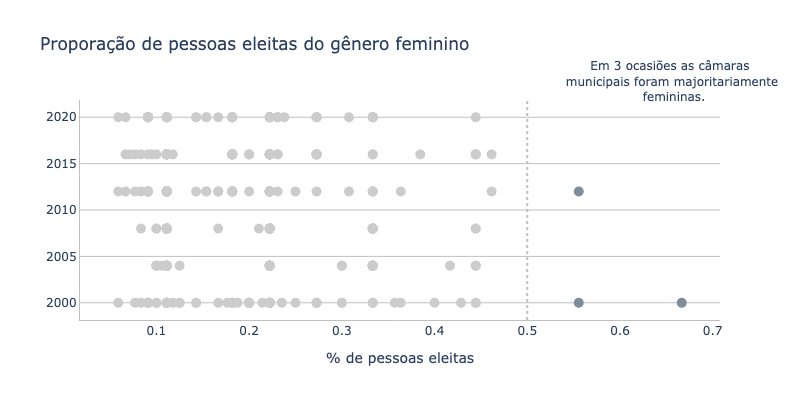

In [68]:
data_filter_municipios['ano'] = data_filter_municipios['ano'].astype('str')

data_filter_municipios = df_vereadores_eleitos_municipios.query("genero == 'feminino' and porcentagem > 0")

data_filter_municipios.loc[data_filter_municipios['porcentagem'] <= 0.5, 'color'] = '#cccccc'
data_filter_municipios.loc[data_filter_municipios['porcentagem'] > 0.5, 'color'] = '#7e8d9b'


fig = go.Figure()
fig.add_trace(go.Scatter(
    y=data_filter_municipios['ano'],
    x=data_filter_municipios['porcentagem'],
    mode="markers",
    marker_size = 10,
    marker_color=data_filter_municipios['color']
))

fig.update_yaxes( 
  showgrid=True,
  gridcolor="#C0C0C0",
  linecolor="#C0C0C0",
  linewidth=1,
  tickfont_size=12
)

fig.update_xaxes(  
  showgrid=False,
  
  linecolor="#C0C0C0",
  linewidth=1
)

fig.update_layout(title="Proporação de pessoas eleitas do gênero feminino",
                  xaxis_title="% de pessoas eleitas",
                  height=400,
                  width=800,
                  plot_bgcolor="#FFFFFF"
                  )

fig.add_vline(x=0.5, line_dash="dot", row='all', col=1, line_color='#c0c0c0')

fig.add_annotation(x=1.1, y=1.2,
            text="Em 3 ocasiões as câmaras <br /> municipais foram majoritariamente <br /> femininas.",
            showarrow=False,
            xref='paper',
            yref='paper',
            width=220,
            xanchor="right"
            )

fig.show("png")

Uma outra informação importante para se extrair destes dados é saber quantas cidades não tiveram nenhuma mulher na composição das câmaras municipais. Esse valor foi filtrado da visualização anterior, mas serão listados a seguir. 

In [74]:
data_zero_feminino = df_vereadores_eleitos_municipios.query("porcentagem == 0")
data_zero_feminino = data_zero_feminino[['ano','id_municipio']]
data_zero_feminino = data_zero_feminino.groupby(by='ano').count()
data_zero_feminino.reset_index(inplace=True)
data_zero_feminino = data_zero_feminino.rename(columns={'id_municipio': 'total'})
data_zero_feminino

,ano,total
0,2000,14
1,2004,17
2,2008,18
3,2012,9
4,2016,13
5,2020,8


O ano de 2020 foi o ano com o menor número de cidades sem mulheres na composição a assembléia municipal. Ainda assim, foram 8 cidades das 75 do estado de Sergipe. 

Para a visualização final, serão utilizadas os dataframes processados nesta etapa. Para isso, esses dados serão salvos na pasta `output` em formato `.csv`. Esses arquivos foram carregados no `ObservableHQ` para alimentar a visualização final que pode ser vista no final deste documento. 

In [75]:
df_vereadores_eleitos_municipios.to_csv("../output/total_vereadores_por_ano_municipio_genero.csv", index=False)

## 5. Visualização Final

As visualizacões criadas neste notebook serviram para o entendimento dos dados e criação da visualização final. Para criação foi utilizada a biblioteca `D3.js` e criada em um notebook no site [ObservableHQ](https://observablehq.com/@adolfoguimaraes/basedosdados-eleicoes). No entanto, o código criado foi exportado e adicionado a pasta `code/viz`. A imagem a seguir foi gerada a partir do código criado. Em seguida, uma breve explicação das decisões de visualização escolhidas. 

<img src='../images/viz_final.png' /> 

A visualização é composta de 3 partes: 

* A primeira parte composta por `gráficos de barras` que ajudam a visualizar em mais detalhes a proporção de mulheres candidatas e eleitas ao longo dos últimos 20 anos. A opção de colocar essas informações em um mesmo sistema de eixos foi para facilitar a comparação. Associada a essa parte, foram colocados dois outros gráficos de barras para o agrupamento de raça. Os gráficos foram colocados de lado do gráfico principal para reforçar que é um recorte dos dados apresentados anteriormente. 
* A segunda parte é formada por um `Unit Chart`. Nesse tipo de gráfico, cada unidade representa uma informação dos dados. Nesse caso, cada quadrado é um candidato eleito para câmara municipal de Aracaju ordenados pelo total de votos. A proposta foi mostrar a posição em relação ao número de votos e ressaltar que em 2020 foi a primeira vez que uma mulher foir eleita como a candidata mais votada.
* Por fim, na terceira parte usei um `Scatter Plot` adapatado para dados categóricos no eixo Y. Isso permite verificar a posição de todos os municípios quando analisamos a % de mulheres eleitas. O objetivo foi mostrar que existe sim uma variação maior do que na média, mas ainda assim, as câmaras municipais se mantém majoritariamente formada por homens.

Ao longo da visualização foram adicionadas anotações e linhas para guiar o usuário no entendimento dos dados apresentados. As anotações tem o intuito de informar e facilitar a interpretação dos gráficos.

As cores escolhidas trabalham com um grau de contraste que permite diferencia-las entre si e destacar as informações de interesse. A combinação de cores foi testada para verificar se pessoas com alguma deficiência visual não conseguiriam distingui-las. O teste pode ser visto no site: https://projects.susielu.com/viz-palette?colors=[%22#d8b365%22,%22#5a6773%22,%22#7e8d9b%22]&backgroundColor=%22white%22&fontColor=%22black%22&mode=%22normal%22. Nenhum conflito foi encontrado entre as cores para diferentes tipos de deficiência visual.

Os arquivos de entrada para essas visualizações estão na pasta `output` e foram gerados no arquivo de Processamento dos Dados. Esses dados são carregados no ObervableHQ para alimentar as visualizações criadas.

